In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
import pandas as pd 
import numpy as np
import os 
import datetime
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.window import Window
from math import radians, cos, sin, asin, sqrt
from pyspark.sql import functions as F
from pyspark.sql.functions import col, row_number

In [3]:
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "48g").config("spark.driver.memory", "48g").config("spark.driver.maxResultSize","0").getOrCreate()

In [4]:
gdrive_path = 'C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data'

In [5]:
df_point_sources = spark.read.option("header",True).csv(os.path.join(gdrive_path, 'Point source/pollution_point_sources.csv'))

In [6]:
df_point_sources = df_point_sources.select('_c0','checked_lat','checked_lon','report_year','PM25_emissions_TPY','combo_zip')

In [7]:
df_point_sources = df_point_sources.withColumnRenamed('_c0','point_source_index')\
.withColumnRenamed('checked_lat','point_source_lat')\
.withColumnRenamed('checked_lon','point_source_lon')\
.withColumnRenamed('report_year','point_source_year')\
.withColumnRenamed('PM25_emissions_TPY','point_source_pm25_tpy')\
.withColumnRenamed('combo_zip','point_source_zip')

df_point_sources.count()

7155

In [8]:
df_point_sources.limit(5).show()

+------------------+----------------+----------------+-----------------+---------------------+----------------+
|point_source_index|point_source_lat|point_source_lon|point_source_year|point_source_pm25_tpy|point_source_zip|
+------------------+----------------+----------------+-----------------+---------------------+----------------+
|                 0|       33.811466|      -117.91555|             2002|          1.787853962|         92803.0|
|                 1|       34.088242|     -117.470116|             2002|               1.7892|         92335.0|
|                 2|       33.911602|     -118.281799|             2002|          1.791299781|         93420.0|
|                 3|       37.944618|     -121.325859|             2002|          1.797499934|         95203.0|
|                 4|       39.221817|     -121.054955|             2002|              1.80154|         95945.0|
+------------------+----------------+----------------+-----------------+---------------------+----------

In [9]:
school_locs = spark.read.option("header",True).csv(os.path.join(gdrive_path, 'schools/filtered_joined_schools_data.csv'))

In [10]:
school_locs = school_locs.select("CDSCode","County","Zip_first_five","OpenDate","ClosedDate","Merged_Lat","Merged_Long")

In [11]:
school_locs = school_locs.withColumnRenamed("County","school_county")\
.withColumnRenamed("Zip_first_five","school_zip")\
.withColumnRenamed("OpenDate","school_open_date")\
.withColumnRenamed("ClosedDate","school_closed_date")\
.withColumnRenamed("Merged_Lat","school_lat")\
.withColumnRenamed("Merged_Long","school_lon")

school_locs.count()

13297

In [12]:
school_locs.limit(5).show()

+-------------+-------------+----------+----------------+------------------+----------+-----------+
|      CDSCode|school_county|school_zip|school_open_date|school_closed_date|school_lat| school_lon|
+-------------+-------------+----------+----------------+------------------+----------+-----------+
|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212| -122.09713|
|1100170109835|      Alameda|     94560|       8/29/2005|         7/31/2015| 37.521436| -121.99391|
|1100170112607|      Alameda|     94612|       8/28/2006|           No Data| 37.804722|-122.268394|
|1100170118489|      Alameda|     94703|       8/21/2008|         6/30/2015| 37.868991| -122.27844|
|1100170123968|      Alameda|     94606|       8/22/2011|           No Data| 37.784653|-122.238651|
+-------------+-------------+----------+----------------+------------------+----------+-----------+



In [13]:
from pyproj import Geod

g = Geod(ellps="WGS84") # Use WGS84 ellipsoid

In [40]:
newyork_lat = 40.+(47./60.); newyork_lon = -73.-(58./60.)
boston_lat = 42.+(15./60.); boston_lon = -71.-(7./60.)
dc_lat = 38.9072; dc_lon = -77.0369
losangeles_lat = 34.0522; losangeles_lon = -118.2437

az12,az21,dist = g.inv(newyork_lon,newyork_lat,boston_lon,boston_lat)
f"{az12:.3f} {az21:.3f} {dist:.3f}"

# compute the azimuths, distances from New York to several
# cities (pass a list)

lons1 = 3*[newyork_lon]; lats1 = 3*[newyork_lat]
lons2 = [boston_lon, dc_lon, losangeles_lon]
lats2 = [boston_lat, dc_lat, losangeles_lat]

az12,az21,dist = g.inv(lons1,lats1,lons2,lats2)
for faz, baz, d in list(zip(az12,az21,dist)):
    print(f"{faz:7.3f} {baz:8.3f} {d:12.3f}")

 54.662 -123.449   288299.735
-127.414   50.619   335283.902
-86.343   65.836  3947232.483


In [14]:
def geod_dist(lat1, lon1, lat2, lon2):
    
    '''Site 2 (lat2/lon2) must be source location (in this case, pollution sites).
       Site 1 (lat1/lon1) must be destination location (schools). AZ12 will look at
       the angle from this point to the schools.'''
    
    az12,az21,dist = g.inv(lon2, lat2, lon1, lat1)
    
    return dist

In [15]:
udf_geod_dist = F.udf(geod_dist)

In [16]:
def geod_angle(lat1, lon1, lat2, lon2):
    
    '''Site 2 (lat2/lon2) must be source location (in this case, pollution sites).
       Site 1 (lat1/lon1) must be destination location (schools). AZ12 will look at
       the angle from this point to the schools.'''
    
    az12,az21,dist = g.inv(lon2, lat2, lon1, lat1)
    
    return az12

In [17]:
udf_geod_angle = F.udf(geod_angle)

In [18]:
schools_pointsources = school_locs.crossJoin(df_point_sources)

#school_locs.count()
#df_point_sources.count()
#schools_pointsources.count()

In [19]:
schools_pointsources.limit(5).show()

+-------------+-------------+----------+----------------+------------------+----------+----------+------------------+----------------+----------------+-----------------+---------------------+----------------+
|      CDSCode|school_county|school_zip|school_open_date|school_closed_date|school_lat|school_lon|point_source_index|point_source_lat|point_source_lon|point_source_year|point_source_pm25_tpy|point_source_zip|
+-------------+-------------+----------+----------------+------------------+----------+----------+------------------+----------------+----------------+-----------------+---------------------+----------------+
|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212|-122.09713|                 0|       33.811466|      -117.91555|             2002|          1.787853962|         92803.0|
|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212|-122.09713|                 1|       34.088242|     -117.470116|             

In [20]:
schools_pointsources = schools_pointsources.withColumn("school_lat",schools_pointsources.school_lat.cast('double'))
schools_pointsources = schools_pointsources.withColumn("school_lon",schools_pointsources.school_lon.cast('double'))
schools_pointsources = schools_pointsources.withColumn("point_source_lat",schools_pointsources.point_source_lat.cast('double'))
schools_pointsources = schools_pointsources.withColumn("point_source_lon",schools_pointsources.point_source_lon.cast('double'))

schools_pointsources.cache()

DataFrame[CDSCode: string, school_county: string, school_zip: string, school_open_date: string, school_closed_date: string, school_lat: double, school_lon: double, point_source_index: string, point_source_lat: double, point_source_lon: double, point_source_year: string, point_source_pm25_tpy: string, point_source_zip: string]

In [21]:
import time

In [22]:
start_time = time.time()

# schools_pointsources = schools_pointsources.withColumn("h_dist_m",\
#                         udf_haversine(schools_pointsources.school_lat,schools_pointsources.school_lon,schools_pointsources.point_source_lat,schools_pointsources.point_source_lon).cast(DoubleType()))

schools_pointsources = schools_pointsources.withColumn("geod_dist_m",\
                        udf_geod_dist(schools_pointsources.school_lat,schools_pointsources.school_lon,schools_pointsources.point_source_lat,schools_pointsources.point_source_lon).cast(DoubleType()))

schools_pointsources = schools_pointsources.withColumn("angle_to_school",\
                        udf_geod_angle(schools_pointsources.school_lat,schools_pointsources.school_lon,schools_pointsources.point_source_lat,schools_pointsources.point_source_lon).cast(DoubleType()))

end_time = time.time()

print(end_time - start_time)

0.06400513648986816


In [23]:
schools_pointsources.cache()

DataFrame[CDSCode: string, school_county: string, school_zip: string, school_open_date: string, school_closed_date: string, school_lat: double, school_lon: double, point_source_index: string, point_source_lat: double, point_source_lon: double, point_source_year: string, point_source_pm25_tpy: string, point_source_zip: string, geod_dist_m: double, angle_to_school: double]

In [24]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [26]:
school_year_window = Window.partitionBy([col("CDSCode"), col("point_source_year")]).orderBy(col("geod_dist_m").asc())

each_school_year_min = schools_pointsources.withColumn("row",row_number().over(school_year_window)).filter(col("row") < 6).withColumnRenamed("row","ps_distance_rank")

In [27]:
%%time

eachschool_year_min_pd = each_school_year_min.toPandas()

CPU times: total: 2.52 s
Wall time: 17min 54s


In [28]:
display(eachschool_year_min_pd)

,CDSCode,school_county,school_zip,school_open_date,school_closed_date,school_lat,school_lon,point_source_index,point_source_lat,point_source_lon,point_source_year,point_source_pm25_tpy,point_source_zip,geod_dist_m,angle_to_school,ps_distance_rank
0,10621171030071,Fresno,93611,7/1/1967,No Data,36.834437,-119.690520,111,36.830643,-119.684105,2002,2.30478261,93612.0,710.460063,-53.654481,1
1,10621171030071,Fresno,93611,7/1/1967,No Data,36.834437,-119.690520,624,36.774975,-119.688148,2002,10.089,93727.0,6602.129320,-1.836595,2
2,10621171030071,Fresno,93611,7/1/1967,No Data,36.834437,-119.690520,787,36.852242,-119.815216,2002,29.2146,93711.0,11296.279671,100.036403,3
3,10621171030071,Fresno,93611,7/1/1967,No Data,36.834437,-119.690520,95,36.727818,-119.774910,2002,2.230020551,93721.0,14026.481929,32.458987,4
4,10621171030071,Fresno,93611,7/1/1967,No Data,36.834437,-119.690520,509,36.748840,-119.812027,2002,6.7392,93706.0,14416.827317,48.748808,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398905,9619526005649,El Dorado,95667,7/1/1980,No Data,38.736181,-120.816026,1952,38.739338,-120.677124,2005,52.709,95709.0,12081.953029,-91.618746,1
398906,9619526005649,El Dorado,95667,7/1/1980,No Data,38.736181,-120.816026,1400,38.655748,-120.965974,2005,4.153700000000001,95682.0,15807.989566,55.562599,2
398907,9619526005649,El Dorado,95667,7/1/1980,No Data,38.736181,-120.816026,934,38.652626,-120.964729,2005,1.749537963,95682.0,15918.379454,54.313883,3
398908,9619526005649,El Dorado,95667,7/1/1980,No Data,38.736181,-120.816026,1305,38.602852,-121.058006,2005,3.441279975,95762.0,25739.919673,54.824054,4


In [55]:
len(eachschool_year_min_pd.point_source_index.unique())

5579

<AxesSubplot:>

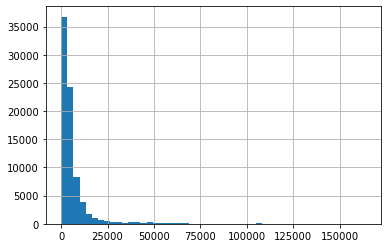

In [56]:
eachschool_year_min_pd.geod_dist_m.hist(bins=50)

<AxesSubplot:>

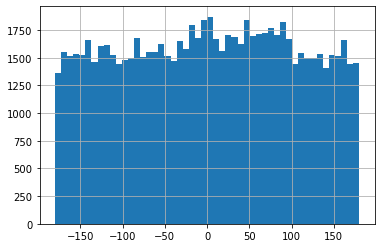

In [57]:
eachschool_year_min_pd.angle_to_school.hist(bins=50)

<AxesSubplot:>

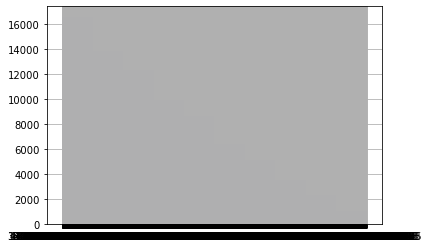

In [58]:
eachschool_year_min_pd.point_source_pm25_tpy.hist()

In [59]:
eachschool_year_min_pd.to_csv('C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\schools\\school_year_to_point_lookup_top_5.csv')

In [60]:
school_distance_to_point_source_max = 2250 # median value of distance to nearest pollution site for each school

In [61]:
point_sources_within_5miles_schools = schools_pointsources.filter(schools_pointsources.geod_dist_m < school_distance_to_point_source_max)

In [63]:
count_point_sources_within_2250m_schools = point_sources_within_5miles_schools.groupBy([col("CDSCode"), col("point_source_year")]).count()

In [64]:
school_2250m_pointsource = count_point_sources_within_2250m_schools.toPandas()

In [65]:
school_2250m_pointsource.to_csv('C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\schools\\pointsources_within_2250m_by_school_by_year.csv')